In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import chain
from collections import Counter

In [2]:
data = pd.read_csv('./indicators.csv')
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [3]:
#Here we are filtering Brazil, for this is the country we are interested in
brazil = data[data['CountryName']=='Brazil']

In [4]:
# Now we need to clean the data, and since this dataset is known not to contain null values, 
# we don't need to worry about those.
# What we need is to find a range of years containing the most number of indicatos
# and when we find that, drop the possible indicators missing in any of the years from that range.

yearAnalysis = brazil[['IndicatorName','Year']].groupby(['IndicatorName']).agg({'Year':['min','max','count'],
                                                                              'IndicatorName':'unique'})
yearAnalysis.columns = yearAnalysis.columns.droplevel(level=0)
yearAnalysis.head()

,min,max,count,unique
IndicatorName,,,,
"2005 PPP conversion factor, GDP (LCU per international $)",2005,2005,1,"[2005 PPP conversion factor, GDP (LCU per inte..."
"2005 PPP conversion factor, private consumption (LCU per international $)",2005,2005,1,"[2005 PPP conversion factor, private consumpti..."
ARI treatment (% of children under 5 taken to a health provider),1996,2007,3,[ARI treatment (% of children under 5 taken to...
Access to electricity (% of population),1990,2012,4,[Access to electricity (% of population)]
"Access to electricity, rural (% of rural population)",1990,2012,4,"[Access to electricity, rural (% of rural popu..."


In [5]:
yearAnalysis[['count']].describe()

# Here we can se that the range of year with most number of indicators is 45 years range

,count
count,1228.000000
mean,28.949511
std,18.737384
min,1.000000
25%,11.000000
50%,26.000000
75%,45.000000
max,56.000000


In [6]:
# So let's find the minimum and maximun year for that range. 
yearTot = yearAnalysis['count'] == 45
yearAnalysis[yearTot]['min'].value_counts()

# We can define that our start year is 1970

1970    173
1965      2
Name: min, dtype: int64

In [7]:
# So our final year has to be 2014, let's check that
yearAnalysis[yearTot]['max'].value_counts()

# It is indeed 2014

2014    173
2013      2
Name: max, dtype: int64

In [8]:
# Creating the indicators list filter that we will use for the algorithm
minYears = yearAnalysis['min'] == 1970
indicators = list(chain.from_iterable(yearAnalysis['unique'][yearTot & minYears]))
brazil = brazil[brazil['IndicatorName'].isin(indicators)]
brazil.shape

(7785, 6)

In [9]:
# Now we have our final DataSet, but something's missing
brazil.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
312020,Brazil,BRA,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,1970,1.641000e+02
312021,Brazil,BRA,"Air transport, passengers carried",IS.AIR.PSGR,1970,3.339800e+06
312022,Brazil,BRA,"Air transport, registered carrier departures w...",IS.AIR.DPRT,1970,1.377000e+05
312027,Brazil,BRA,Average grace period on new external debt comm...,DT.GPA.DPPG,1970,3.432100e+00
312028,Brazil,BRA,Average grace period on new external debt comm...,DT.GPA.OFFT,1970,5.624000e+00


In [10]:
# Our target Indicator "GDP per capita (constant 2005 US$)" ranges from 1960 to 2014, 
# So it's not in the brazil DataSet. Let's get those missing data 
country = data['CountryName'] == 'Brazil'
targetIndicator = data['IndicatorName']=='GDP per capita (constant 2005 US$)'
years = [i for i in range(1970,2015)]
yearsRange = data['Year'].isin(years)
missing = data[targetIndicator & yearsRange & country]
missing.shape

(45, 6)

In [11]:
# Now we can merge those two dataframes together to, finally, have our final DataSet
frames = [brazil,missing]
final = pd.concat(frames)
final.shape

(7830, 6)

In [12]:
# Since our Indicator data is not arranged as columns, we need to Pivot the DataFrame to 
# get the desirable data format.
finaldf = final.pivot(index='Year', columns='IndicatorName', values='Value')
finaldf.head()

IndicatorName,"Air transport, freight (million ton-km)","Air transport, passengers carried","Air transport, registered carrier departures worldwide",Average grace period on new external debt commitments (years),"Average grace period on new external debt commitments, official (years)","Average grace period on new external debt commitments, private (years)",Average grant element on new external debt commitments (%),"Average grant element on new external debt commitments, official (%)","Average grant element on new external debt commitments, private (%)",Average interest on new external debt commitments (%),...,Public and publicly guaranteed debt service (% of GNI),Short-term debt (% of total external debt),Short-term debt (% of total reserves),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Total debt service (% of GNI),"Undisbursed external debt, official creditors (UND, current US$)","Undisbursed external debt, private creditors (UND, current US$)","Undisbursed external debt, total (UND, current US$)","Use of IMF credit (DOD, current US$)"
Year,,,,,,,,,,,,,,,,,,,,,
1970,164.100006,3339800.0,137700.0,3.4321,5.6240,2.2442,19.0174,31.9055,12.0326,6.7313,...,0.965909,11.9318,60.006572,4.0,7.0,1.838597,1.038351e+09,8.406120e+08,1.878963e+09,0.0
1971,180.199997,3911000.0,149300.0,3.7394,6.0322,2.2015,15.1950,28.0508,6.5724,7.1702,...,1.051395,11.9465,52.627924,4.0,7.0,1.805234,1.320914e+09,1.023012e+09,2.343926e+09,0.0
1972,254.300003,4671400.0,156700.0,3.6206,5.2322,2.4618,14.3322,21.2468,9.3603,7.0888,...,1.137205,11.9295,33.541428,4.0,7.0,2.072370,1.944113e+09,7.894100e+08,2.733523e+09,0.0
1973,316.700012,5842400.0,173200.0,3.9078,4.7361,3.5578,7.0148,18.4949,2.1647,8.5966,...,1.240894,11.9677,27.670786,4.0,7.0,2.453181,2.174326e+09,7.820010e+08,2.956327e+09,0.0
1974,407.100006,6855500.0,204800.0,3.6926,3.8111,3.6571,0.5951,18.4696,-4.7604,9.8925,...,1.207161,12.0369,49.458963,4.0,7.0,3.282395,2.249072e+09,1.179551e+09,3.428623e+09,0.0


In [13]:
# Now we create a DataFrame for all other variables, except the target
columns = list(finaldf.columns)
print(columns.count('GDP per capita (constant 2005 US$)'))
columns.remove('GDP per capita (constant 2005 US$)')
print(columns.count('GDP per capita (constant 2005 US$)'))
x = finaldf[columns]
x.head()

1
0


IndicatorName,"Air transport, freight (million ton-km)","Air transport, passengers carried","Air transport, registered carrier departures worldwide",Average grace period on new external debt commitments (years),"Average grace period on new external debt commitments, official (years)","Average grace period on new external debt commitments, private (years)",Average grant element on new external debt commitments (%),"Average grant element on new external debt commitments, official (%)","Average grant element on new external debt commitments, private (%)",Average interest on new external debt commitments (%),...,Public and publicly guaranteed debt service (% of GNI),Short-term debt (% of total external debt),Short-term debt (% of total reserves),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Total debt service (% of GNI),"Undisbursed external debt, official creditors (UND, current US$)","Undisbursed external debt, private creditors (UND, current US$)","Undisbursed external debt, total (UND, current US$)","Use of IMF credit (DOD, current US$)"
Year,,,,,,,,,,,,,,,,,,,,,
1970,164.100006,3339800.0,137700.0,3.4321,5.6240,2.2442,19.0174,31.9055,12.0326,6.7313,...,0.965909,11.9318,60.006572,4.0,7.0,1.838597,1.038351e+09,8.406120e+08,1.878963e+09,0.0
1971,180.199997,3911000.0,149300.0,3.7394,6.0322,2.2015,15.1950,28.0508,6.5724,7.1702,...,1.051395,11.9465,52.627924,4.0,7.0,1.805234,1.320914e+09,1.023012e+09,2.343926e+09,0.0
1972,254.300003,4671400.0,156700.0,3.6206,5.2322,2.4618,14.3322,21.2468,9.3603,7.0888,...,1.137205,11.9295,33.541428,4.0,7.0,2.072370,1.944113e+09,7.894100e+08,2.733523e+09,0.0
1973,316.700012,5842400.0,173200.0,3.9078,4.7361,3.5578,7.0148,18.4949,2.1647,8.5966,...,1.240894,11.9677,27.670786,4.0,7.0,2.453181,2.174326e+09,7.820010e+08,2.956327e+09,0.0
1974,407.100006,6855500.0,204800.0,3.6926,3.8111,3.6571,0.5951,18.4696,-4.7604,9.8925,...,1.207161,12.0369,49.458963,4.0,7.0,3.282395,2.249072e+09,1.179551e+09,3.428623e+09,0.0


In [14]:
# And extract the Target "GDP per capita (constant 2005 US$)" values into Separate DataFrame
y = finaldf[['GDP per capita (constant 2005 US$)']]
y.head()

IndicatorName,GDP per capita (constant 2005 US$)
Year,
1970,2346.609691
1971,2547.439563
1972,2785.349337
1973,3098.613305
1974,3298.175794


In [15]:
# Here we're creating the train and test DataFrames
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=324)

<p style="font-family: Arial; font-size:1.75em;color:black; font-style:bold"><br>
1st Algorithm Test: Linear Regression
<br><br></p>

In [16]:
regressor1 = LinearRegression()
regressor1.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
y_prediction1 = regressor1.predict(x_test)
y_prediction1

array([[ 2376.86377957],
       [ 4364.11874559],
       [ 2764.14688791],
       [ 4475.32125319],
       [ 4116.65621253],
       [ 3333.20987209],
       [ 4952.69865368],
       [ 3534.41038817],
       [ 5302.31631286],
       [ 4179.50347967],
       [ 3598.01749828],
       [ 3614.65568045],
       [ 4022.3099503 ],
       [ 6702.04795808]])

In [18]:
y_test.describe()

IndicatorName,GDP per capita (constant 2005 US$)
count,14.000000
mean,3954.280038
std,853.975662
min,2346.609691
25%,3467.298196
50%,4067.589503
75%,4300.805678
max,5791.295487


In [19]:
print('Mean:', y_prediction1.mean(),'\n', 'Max:',y_prediction1.max(),'\n','Min:' ,y_prediction1.min())

Mean: 4095.44833374 
 Max: 6702.04795808 
 Min: 2376.86377957


In [20]:
# Evaluate Linear Regression Accuracy using Root Mean Square Error
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction1))
print(RMSE)

420.6687338540806


<p style="font-family: Arial; font-size:1.75em;color:black; font-style:bold"><br>
2nd Algorithm Test: Decision Tree Regressor
<br><br></p>

In [66]:
regressor2 = DecisionTreeRegressor(max_depth=20)
regressor2.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [67]:
y_prediction2 = regressor2.predict(x_test)
y_prediction2

array([ 2547.4395629 ,  4162.25327892,  2547.4395629 ,  3975.20167824,
        4279.47634013,  3596.29710698,  4330.88906901,  3596.29710698,
        4646.92788637,  3895.65839016,  4457.58644947,  3630.33338949,
        3981.70760441,  5852.49975957])

In [68]:
y_test.describe()

IndicatorName,GDP per capita (constant 2005 US$)
count,14.000000
mean,3954.280038
std,853.975662
min,2346.609691
25%,3467.298196
50%,4067.589503
75%,4300.805678
max,5791.295487


In [69]:
print('Mean:', y_prediction2.mean(),'\n', 'Max:',y_prediction2.max(),'\n','Min:' ,y_prediction2.min())

Mean: 3964.28622754 
 Max: 5852.49975957 
 Min: 2547.4395629


In [70]:
# Evaluate Decision Tree Regression Accuracy using Root Mean Square Error
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction2))
print(RMSE)

162.15678345003977


<p style="font-family: Arial; font-size:1.75em;color:black; font-style:bold"><br>
Results Visualization
<br><br></p>

In [94]:
# Running all data on both algorithms for visualization comparison
y_visualization1 = regressor1.predict(x)
y_visualization2 = regressor2.predict(x)

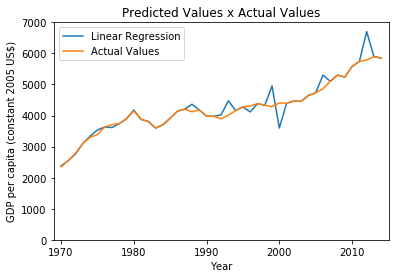

In [147]:
# Linear Regression Plot
fig1, ax1 = plt.subplots()

ax1.plot(years,y_visualization1, 
        label = 'Linear Regression') 
ax1.plot(years,y,
        label = 'Actual Values')

ax1.legend(loc = 'upper left')
ax1.axis([1969,2015,0,7000])

plt.xlabel('Year')
plt.ylabel('GDP per capita (constant 2005 US$)')
plt.title('Predicted Values x Actual Values')

plt.show()

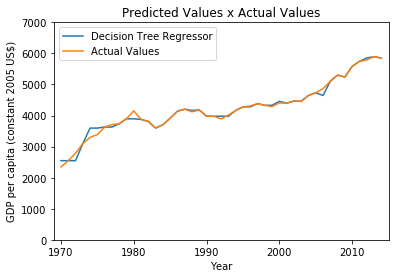

In [148]:
# Decision Tree Regressor Plot
fig2, ax2 = plt.subplots()

ax2.plot(years, y_visualization2,
         label = 'Decision Tree Regressor')
ax2.plot(years,y,
         label = 'Actual Values')

ax2.legend(loc = 'upper left')
ax2.axis([1969,2015,0,7000])

plt.xlabel('Year')
plt.ylabel('GDP per capita (constant 2005 US$)')
plt.title('Predicted Values x Actual Values')
#plt.ticklabel_format(fontsize='large')

plt.show()